# Import libraries 

In [1]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import nltk
nltk.download('stopwords')
import scapy
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby
from textblob import TextBlob

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#transformers

#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

#os and warnings
import os
import random
import warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
warnings.filterwarnings('ignore')
nltk.download('punkt')

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample

import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<Figure size 640x480 with 0 Axes>

# Check GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu


# Import data

In [3]:
df = pd.read_csv("LABR.tsv",sep='\t')
df.columns = ['label' , 'ID1' , 'ID2' , 'ID3' , 'sentence']
cleaned = df.drop(['ID1' , 'ID2' , 'ID3'], axis=1)
cleaned.head()

,label,sentence
0,4,من أمتع ما قرأت من روايات بلا شك. وحول الشك ت...
1,4,رواية تتخذ من التاريخ ،جوًا لها اختار المؤلف ...
2,1,إني أقدّر هذه الرواية كثيرا، لسبب مختلف عن أس...
3,5,الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالع...
4,5,"""عزازيل"" هو اسم رواية يوسف زيدان الثانية و ال..."


In [4]:
def mark_sentiment(rating):
    if(rating<3):
        return 0
    elif (rating == 3):
        return 2
    else:
        return 1

In [5]:
cleaned['label'] = cleaned['label'].apply(lambda x:mark_sentiment(x))
cleaned.head()

,label,sentence
0,1,من أمتع ما قرأت من روايات بلا شك. وحول الشك ت...
1,1,رواية تتخذ من التاريخ ،جوًا لها اختار المؤلف ...
2,0,إني أقدّر هذه الرواية كثيرا، لسبب مختلف عن أس...
3,1,الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالع...
4,1,"""عزازيل"" هو اسم رواية يوسف زيدان الثانية و ال..."


In [6]:
stops = set(stopwords.words("arabic"))
stop_word_comp = {"،","آض","آمينَ","آه","آهاً","آي","أ","أب","أجل","أجمع","أخ","أخذ","أصبح","أضحى","أقبل","أقل","أكثر","ألا","أم","أما","أمامك","أمامكَ","أمسى","أمّا","أن","أنا","أنت","أنتم","أنتما","أنتن","أنتِ","أنشأ","أنّى","أو","أوشك","أولئك","أولئكم","أولاء","أولالك","أوّهْ","أي","أيا","أين","أينما","أيّ","أَنَّ","أََيُّ","أُفٍّ","إذ","إذا","إذاً","إذما","إذن","إلى","إليكم","إليكما","إليكنّ","إليكَ","إلَيْكَ","إلّا","إمّا","إن","إنّما","إي","إياك","إياكم","إياكما","إياكن","إيانا","إياه","إياها","إياهم","إياهما","إياهن","إياي","إيهٍ","إِنَّ","ا","ابتدأ","اثر","اجل","احد","اخرى","اخلولق","اذا","اربعة","ارتدّ","استحال","اطار","اعادة","اعلنت","اف","اكثر","اكد","الألاء","الألى","الا","الاخيرة","الان","الاول","الاولى","التى","التي","الثاني","الثانية","الذاتي","الذى","الذي","الذين","السابق","الف","اللائي","اللاتي","اللتان","اللتيا","اللتين","اللذان","اللذين","اللواتي","الماضي","المقبل","الوقت","الى","اليوم","اما","امام","امس","ان","انبرى","انقلب","انه","انها","او","اول","اي","ايار","ايام","ايضا","ب","بات","باسم","بان","بخٍ","برس","بسبب","بسّ","بشكل","بضع","بطآن","بعد","بعض","بك","بكم","بكما","بكن","بل","بلى","بما","بماذا","بمن","بن","بنا","به","بها","بي","بيد","بين","بَسْ","بَلْهَ","بِئْسَ","تانِ","تانِك","تبدّل","تجاه","تحوّل","تلقاء","تلك","تلكم","تلكما","تم","تينك","تَيْنِ","تِه","تِي","ثلاثة","ثم","ثمّ","ثمّة","ثُمَّ","جعل","جلل","جميع","جير","حار","حاشا","حاليا","حاي","حتى","حرى","حسب","حم","حوالى","حول","حيث","حيثما","حين","حيَّ","حَبَّذَا","حَتَّى","حَذارِ","خلا","خلال","دون","دونك","ذا","ذات","ذاك","ذانك","ذانِ","ذلك","ذلكم","ذلكما","ذلكن","ذو","ذوا","ذواتا","ذواتي","ذيت","ذينك","ذَيْنِ","ذِه","ذِي","راح","رجع","رويدك","ريث","رُبَّ","زيارة","سبحان","سرعان","سنة","سنوات","سوف","سوى","سَاءَ","سَاءَمَا","شبه","شخصا","شرع","شَتَّانَ","صار","صباح","صفر","صهٍ","صهْ","ضد","ضمن","طاق","طالما","طفق","طَق","ظلّ","عاد","عام","عاما","عامة","عدا","عدة","عدد","عدم","عسى","عشر","عشرة","علق","على","عليك","عليه","عليها","علًّ","عن","عند","عندما","عوض","عين","عَدَسْ","عَمَّا","غدا","غير","ـ","ف","فان","فلان","فو","فى","في","فيم","فيما","فيه","فيها","قال","قام","قبل","قد","قطّ","قلما","قوة","كأنّما","كأين","كأيّ","كأيّن","كاد","كان","كانت","كذا","كذلك","كرب","كل","كلا","كلاهما","كلتا","كلم","كليكما","كليهما","كلّما","كلَّا","كم","كما","كي","كيت","كيف","كيفما","كَأَنَّ","كِخ","لئن","لا","لات","لاسيما","لدن","لدى","لعمر","لقاء","لك","لكم","لكما","لكن","لكنَّما","لكي","لكيلا","للامم","لم","لما","لمّا","لن","لنا","له","لها","لو","لوكالة","لولا","لوما","لي","لَسْتَ","لَسْتُ","لَسْتُم","لَسْتُمَا","لَسْتُنَّ","لَسْتِ","لَسْنَ","لَعَلَّ","لَكِنَّ","لَيْتَ","لَيْسَ","لَيْسَا","لَيْسَتَا","لَيْسَتْ","لَيْسُوا","لَِسْنَا","ما","ماانفك","مابرح","مادام","ماذا","مازال","مافتئ","مايو","متى","مثل","مذ","مساء","مع","معاذ","مقابل","مكانكم","مكانكما","مكانكنّ","مكانَك","مليار","مليون","مما","ممن","من","منذ","منها","مه","مهما","مَنْ","مِن","نحن","نحو","نعم","نفس","نفسه","نهاية","نَخْ","نِعِمّا","نِعْمَ","ها","هاؤم","هاكَ","هاهنا","هبّ","هذا","هذه","هكذا","هل","هلمَّ","هلّا","هم","هما","هن","هنا","هناك","هنالك","هو","هي","هيا","هيت","هيّا","هَؤلاء","هَاتانِ","هَاتَيْنِ","هَاتِه","هَاتِي","هَجْ","هَذا","هَذانِ","هَذَيْنِ","هَذِه","هَذِي","هَيْهَاتَ","و","و6","وا","واحد","واضاف","واضافت","واكد","وان","واهاً","واوضح","وراءَك","وفي","وقال","وقالت","وقد","وقف","وكان","وكانت","ولا","ولم","ومن","مَن","وهو","وهي","ويكأنّ","وَيْ","وُشْكَانََ","يكون","يمكن","يوم","كان","ّأيّان"}

In [7]:
st = ISRIStemmer()
def stemNLTK(text):
    # tokenize
    zen = TextBlob(text)
    words = zen.words
    cleaned = list()
    for w in words:
        ty = st.stem(w)
        cleaned.append(ty)
    return " ".join(cleaned)

stemNLTK("كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله ")

'كتب رئع عقد ان ريه كله لخص جمل'

In [8]:
def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)

normalizeArabic("مَرَّتْ أوَانَ العِيدِ بَيْنَ نَوَاهِدٍ مِثْلِ الشُّمُوسِ لِحَاظُهُنَّ ظِبَاء")

'مرت اوان العيد بين نواهد مثل الشموس لحاظهن ظباء'

In [9]:
def remove_stop_words(text):
    zen = TextBlob(text)
    words = zen.words
    return " ".join([w for w in words if not w in stops and not w in stop_word_comp and len(w) >= 2])

remove_stop_words("مرت اوان العيد بين نواهد مثل الشموس لحاظهن ظباء")

'مرت اوان العيد نواهد الشموس لحاظهن ظباء'

In [10]:
def clean_text(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)  # remove punctuation
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    ## Convert text to lowercases
    text = text.lower()
    ## Remove stop words
    text = remove_stop_words(text)
    ## Remove numbers
    text = re.sub("\d+", " ", text)
    ## Remove Tashkeel
    text = normalizeArabic(text)
    #text = re.sub('\W+', ' ', text)
    text = re.sub('[A-Za-z]+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    #Stemming
    text = stemNLTK(text)
    return text

In [11]:
%time
cleaned['sentence'] = cleaned['sentence'].apply(lambda x:clean_text(x))
cleaned.head()

Wall time: 0 ns


,label,sentence
0,1,متع قرت روي بلا شك وحل الش دند عزازيل بلا هده ...
1,1,ريه تخذ ارخ جوا خار ءلف فتر ارخ ندر نول روء كت...
2,0,اني قدر ريه سبب خلف سبب اخر انه علم درس قيم عب...
3,1,كهن طلق اسم هيب تيم علم وثن هيب فر قرت وشت امه...
4,1,عزازيل اسم ريه وسف زيد صدر ءخر دار شرق جذب اسم...


In [13]:
cleaned['sentence'].duplicated().sum()

3944

In [14]:
cleaned.drop_duplicates("sentence", inplace=True)
data = cleaned

# Calculate Length of sentence and preprocessing

In [15]:
text_len = []
for text in data.sentence:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
data['text_len'] = text_len

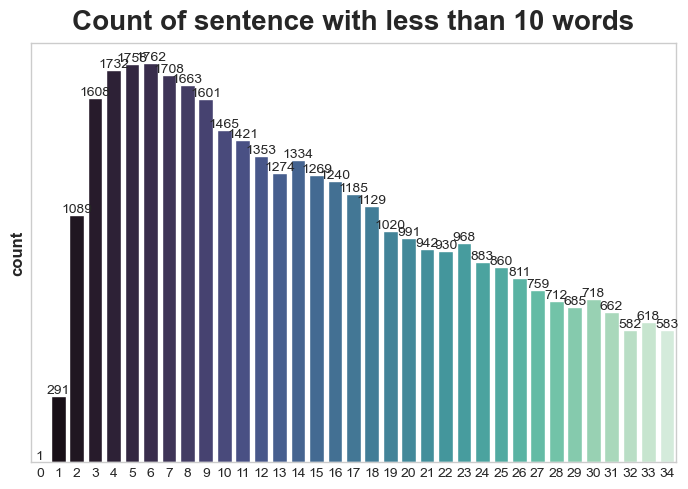

In [16]:
plt.figure(figsize=(7,5))

ax = sns.countplot(x='text_len', data=data[data['text_len'] < 35 ], palette='mako')
plt.title('Count of sentence with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [17]:
data = data[data['text_len'] > 1]

In [18]:
data.sort_values(by=['text_len'], ascending=False)

,label,sentence,text_len
44671,1,اه اه طرق سلك ربم اكن لتم حصل نسخ كتب رهب ماع ...,2141
1846,1,لحب حدث بين ادب حدث هنء ادب فجع فما كبر سحه حد...,2140
12808,1,قطف كتب طبءع بدد صرع عبد كتب عبد رحم ككب بدد ك...,2112
21587,1,كتب شيماء عيس عرض دكتور عبدالوهاب سير صحب وسع ...,2020
10737,1,نسي حلم مستغانمي اجب تحب مره ونس ينس رجل جمع ت...,1759
...,...,...,...
1702,1,كتب فيد,2
1710,2,جمل حلو,2
39181,1,عشق كتب,2
39177,1,صلل يقن,2


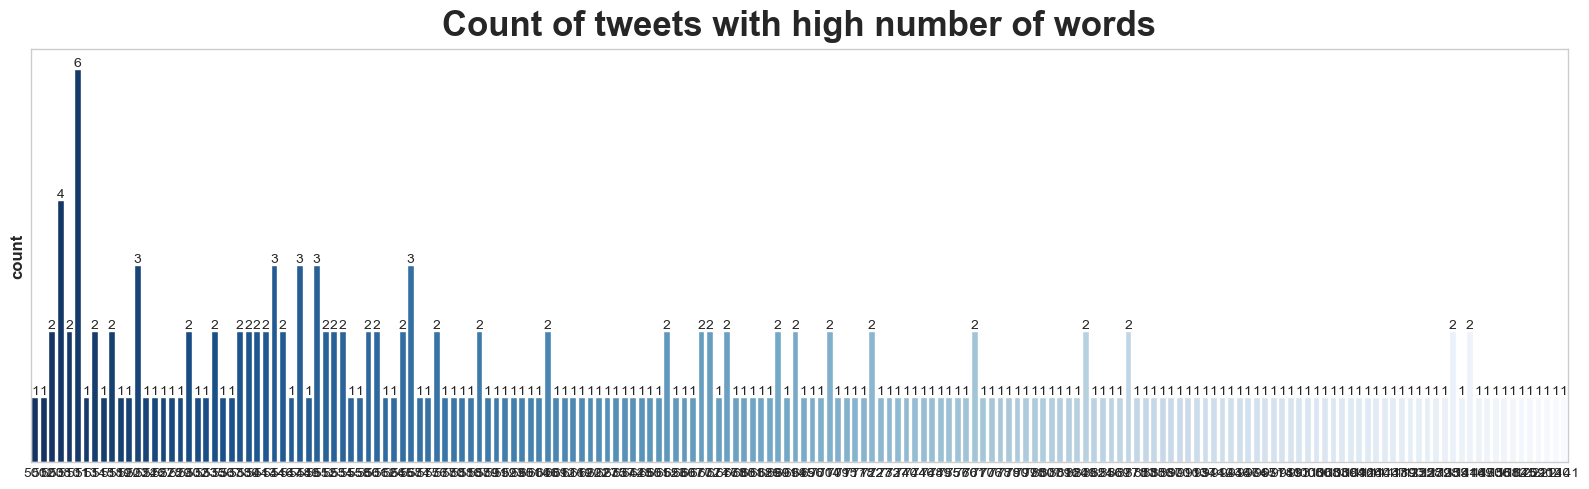

In [19]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=data[(data['text_len']<=2141) & (data['text_len']>500)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

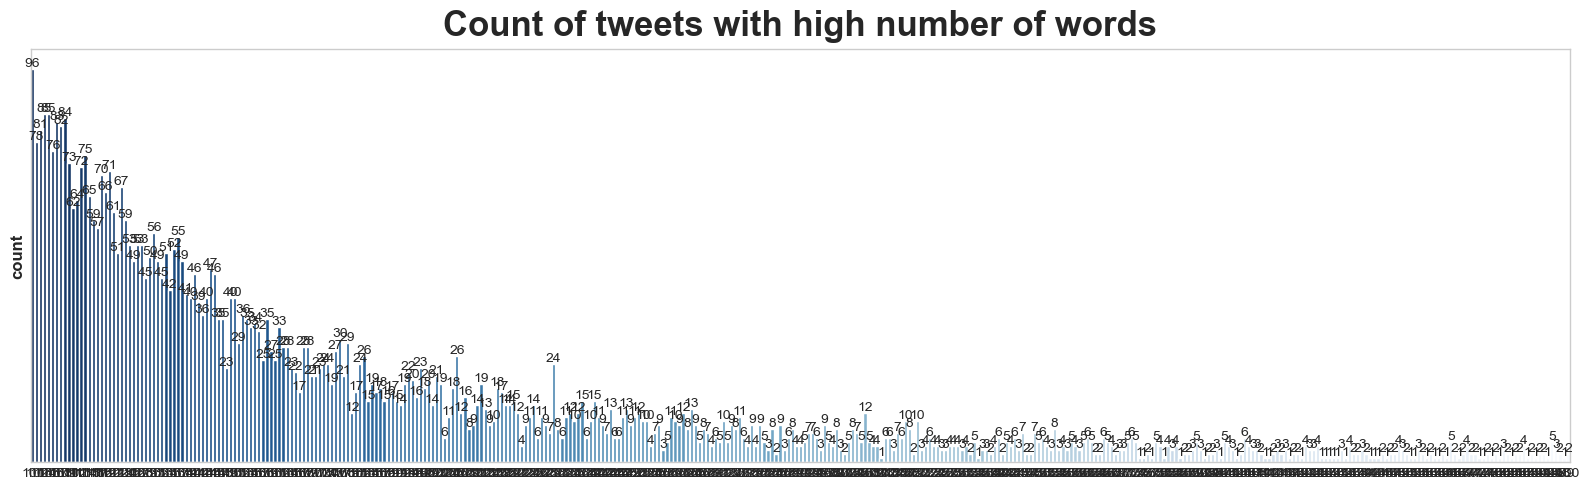

In [20]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=data[(data['text_len']<=500) & (data['text_len']>100)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [21]:
data = data[data['text_len'] < 140]

In [22]:
max_len = np.max(data['text_len'])
max_len 

139

In [23]:
data.label.value_counts()

1    37469
2    10844
0     7365
Name: label, dtype: int64

In [24]:
data.sort_values(by=["text_len"], ascending=False)

,label,sentence,text_len
52556,1,ريه تثر شجن نفس لهو ءلم تقر ريه كتب ستن وضع را...,139
41330,2,ريه نصف تمس دخل فصل جني قدم شيء حدث سبب خلل بن...,139
39475,2,بسم درج عصافير فرح دخل قفص صدر طلق سرح ب ضحك ل...,139
28959,2,ريه اقر عبد رحم نيف فهذ كتب تمز سلب رقي قدم قر...,139
62459,1,نقل طلب عدل وليس ساا رجل شيخ ءكد شرع سلم فعل ن...,139
...,...,...,...
12224,1,بتح مصر,2
36283,1,قرء مره,2
23708,1,وطن حدث,2
31024,1,نهي دهش,2


# Balancing Data Classes


In [25]:
data.label.value_counts()

1    37469
2    10844
0     7365
Name: label, dtype: int64

In [26]:
data = data[data['label'] < 2]

<AxesSubplot:xlabel='label', ylabel='count'>

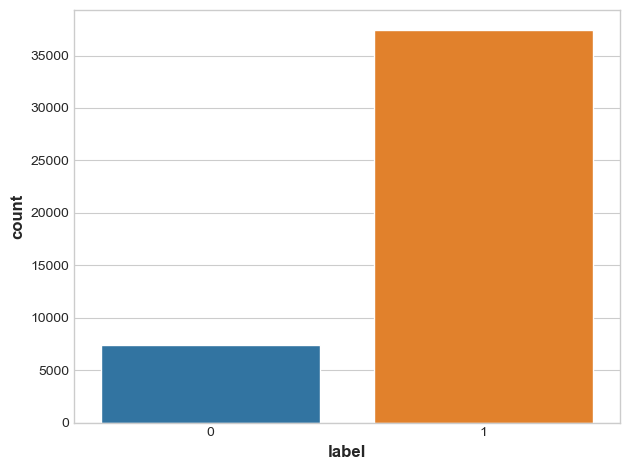

In [27]:
sns.countplot(x=data["label"])

In [28]:
#datasetNeg , datasetPos, = (g for _,g in data.groupby('label'))
#datasetPos = datasetPos.iloc[(37469 - 7365 ) : ]
#data = pd.concat([datasetPos,datasetNeg])
#data.label.value_counts()

1    7365
0    7365
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

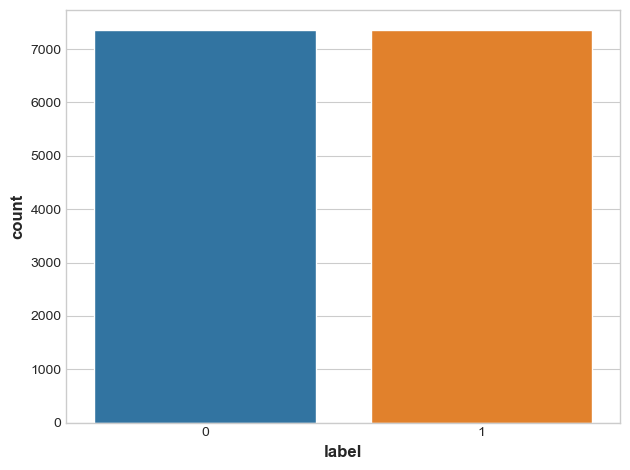

In [29]:
sns.countplot(x=data["label"])

# Train and test and validation splitting

In [30]:
X = data['sentence']
y = data['label']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

# Create Models

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC , SVR
vectorizer=TfidfVectorizer() 

In [47]:
clf=SVC(kernel='rbf')

In [48]:
from sklearn.pipeline import make_pipeline
pipe=make_pipeline(vectorizer,clf)

In [49]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())])

In [50]:
y_pred=pipe.predict(X_test)


In [51]:
print(y_pred[1])

1


In [52]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y_test,y_pred)

0.8109300746775289

In [53]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)

In [54]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

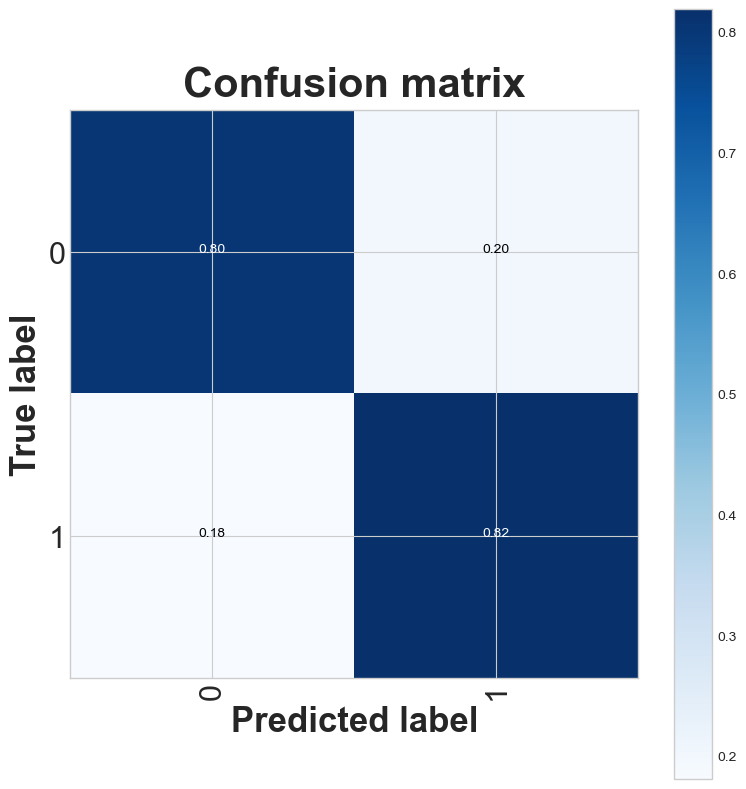

In [55]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes={0,1}, title="Confusion matrix")
plt.show()